**哥斯达黎加家庭贫困水平预测**

美洲开发银行请求Kaggle社区为世界上一些最贫困的家庭做出帮助。
官网： https://www.kaggle.com/c/costa-rican-household-poverty-prediction 

背景是：银行需要评定人们的生活贫困状态等级，在拉丁美洲，一种流行的方法使用一种算法来验证收入资格。它被称为代理测试（PMT）。也就是根据人们的家庭情况，例如家里的墙壁和天花板的材料，生存环境等信息进行贫困度评估。
我们希望通过机器学习提高PMT评估的准确性。

这是一个Kaggle内核竞赛，必须通过内核提交代码，而不是上传CSV预测结果。内核竞赛就是所有操作需要在Kaggle提供的机器上计算完成。内核算力一般，我没用GPU的情况下4核CPU算力和I3 应该差不多。

**相对于排名，我更希望看重对于模型有新的尝试和理解其中原理**
包括
1. 不平衡数据量的处理和原理，如何影响树模型生长
2. 调参在测试集远大于训练集时是否有负面作用
3. 学习率逐步减少的作用，如何影响LightGBM训练

这才是比赛带来的真的东西， 排名靠前或多或少得靠运气和技巧。

由于以前详细记录过其他比赛的全过程，这一篇对于异常值处理和特征的说明较少， 但是包含了完整的提交流程：

1 数据探索与数据预处理
1.1 赛题回顾
1.2 数据探索性分析与异常值处理

2 特征工程
2.1 新特征构建
2.2 个人特征向家庭特征的综合

3 模型构建与调试
3.1 LightGBM的使用和融合



数据认知和基本模型参照https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough 
作者Will 写的文章看起来一直会受益匪浅。

最终通过5个有差异LightGBM投票最为最终结果，单模型可以达到前10的成绩，融合模型可以做到前5。
关于以下三个问题还请多指点讨论，网上能找到的讨论很少，我参考了几篇原论文试图更好的理解。
1. 不平衡数据量的处理和原理，如何影响树模型生长
2. 调参的限制，在测试集远大于训练集时的负面作用
3. 学习率逐步减少的作用，如何影响LightGBM训练

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set a few plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

**读入数据**
训练数据train.csv, 9557行，每行一个人，143列，也就是142个特征，加上一个目标列，从家庭人口状况直到装修状况，具体可参考https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough/data 对于142个特征的解释说明。

测试数据test.csv， 23856行。

目标列：个人贫穷程度的分类，有4个等级
1 = 极度贫穷
2 = 比较贫穷
3 = 有贫穷的可能性
4 = 不贫穷

准确度评价指标是Macro F1=(F1 Class 1+F1 Class 2+F1 Class 3+F1 Class 4)/4 

In [ ]:
pd.options.display.max_columns = 150

# Read in data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.head()

In [ ]:
train.info()

In [ ]:
from collections import OrderedDict

**简单数据探索**
这个数据集比较完整，画图分析一些特征和目标的关系。用的是KDE plot，数据分布情况，那么好的特征，四种贫穷程度，即四种颜色的分布应该交集较少，代表该特征能较好的用于区别贫穷程度。

特征举例说明 
V2a1: 每月房租
V18q1: 家庭拥有的桌子的数量

In [ ]:
plt.figure(figsize = (20, 12))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

for i,col in enumerate(train.select_dtypes('float')):
    ax=plt.subplot(4,2,i+1)
    for poverty_level,color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
        
plt.subplots_adjust(top = 2)

查看数据集中非纯数字的列，发现数值和分类变量混杂，需要进一步处理，对于几个特征的解释如下：

dependency：计算抚养率=(19岁以下或64岁以上家庭成员数)/(19至64岁家庭成员数)

edjefe：男户主受教育年限，基于escolari （受教育年限）、户主和性别，是=1，否=0

edjefa：女户主受教育年限，基于escolari （受教育年限）、户主和性别，是=1，否=0

In [ ]:
train.select_dtypes('object').head()

基于特征的解释说明，dependency和edjefe	，edjefa替换yes no 为 1 和 0 

In [ ]:
map={'yes':1,"no":0}
for df in [train,test]:
    df['dependency']=df['dependency'].replace(map).astype(np.float64)
    df['edjefe']=df['edjefe'].replace(map).astype(np.float64)
    df['edjefa']=df['edjefa'].replace(map).astype(np.float64)
train[['dependency','edjefe','edjefa']].describe()

查看这几个特征的KDE plot

In [ ]:
plt.figure(figsize = (20, 16))
plt.style.use('ggplot')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

for i,col in enumerate(['dependency','edjefe','edjefa']):
    ax=plt.subplot(3,1,i+1)
    for poverty_level,color in colors.items():
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')
        


混合test 和 train

In [ ]:
test['Target']=np.nan
data=train.append(test,ignore_index=True)

可以发现在四个贫穷程度里面，极度贫穷的人很少，四个类别样本数量严重不均衡，这样机器学习模型会很少几率学习来自于极度贫穷的样本，导致预测不准确。样本数量不平衡通常比较好的解决方式是在模型样本上加权重，在本题中只需要lightGBM 设置 class_weight 参数 为 ‘balanced' 。

关于这样做的影响，sklearn 官方文档只说了这样的想法是受到“Logistic Regression in Rare Events Data, King, Zen, 2001." 启发，去参考原文，原文提出了不平衡样本下的逻辑回归修正，作者通过同时使用 1. Prior Correction 2. Weighting 改变了最大似然估计 估计参数的过程和结果，改变过程是用Weighting对于最大似然估计取最大值的过程加权，就是样本少的类别权重大，相对于没加权的情况改变了参数的估计值。Prior Correction则是直接修正参数的值。 Prior Correction 修正幅度和Weighting加权的权的值，直接和不平衡样本每类数量的比例有关。
Prior Correction
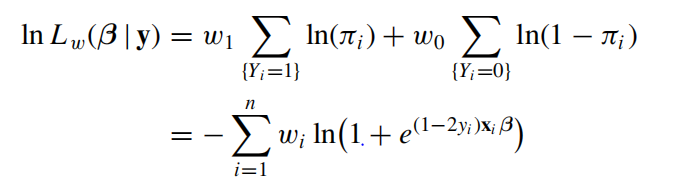
 Weighting （Wi)
 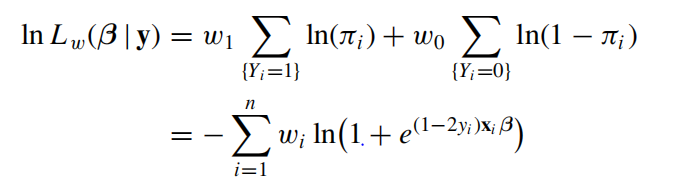

对于LigthGBM来说，从源代码可以发现，weighting影响了树的生长过程，举简单例子和代码说明，来源参考
https://stackoverflow.com/questions/34389624/what-does-sample-weight-do-to-the-way-a-decisiontreeclassifier-works-in-skle


In [ ]:
from sklearn.tree import DecisionTreeClassifier as DTC

X = [[0],[1],[2]] # 3 simple training examples
Y = [ 1,  2,  1 ] # class labels
#最多分裂一层，即一个root节点，两个leaf节点
dtc = DTC(max_depth=1)

In [ ]:
#不带权重拟合决策树
dtc.fit(X,Y)
#结果：0.5是左leaf的标准, 即第一个样本[0]被分入左leaf节点
print (dtc.tree_.threshold)
# [0.5, -2, -2]
#计算不纯度，root+左右leaf,基尼指数
print ( dtc.tree_.impurity)
# [0.44444444, 0, 0.5]

In [ ]:
#给三个样本不同权重，再拟合新的决策树
dtc.fit(X,Y,sample_weight=[1,2,3])
#
print (dtc.tree_.threshold)
# [1.5, -2, -2]
print (dtc.tree_.impurity)
# [0.44444444, 0.44444444, 0.]

可以发现，加了样本权重之后，树的分裂标准，叶子节点不纯度都会随之改变。这样也就相对于没有加样本权重，模型的参数做出了改变。



In [ ]:
data['Target'].value_counts()

由于测试只看户主 （['parentesco1'] == 1）的贫穷程度，直接提取所有户主作为训练集，有2973个户主

In [ ]:
heads=data.loc[data['parentesco1'] == 1].copy()
train_labels=data.loc[(data['Target'].notnull())&(data['parentesco1']==1),['Target','idhogar']]

In [ ]:
len(train_labels)

In [ ]:
type_counts=train_labels['Target'].value_counts()

In [ ]:
type_counts=pd.DataFrame(type_counts)

In [ ]:
type_counts['level']=type_counts.index

In [ ]:
type_counts['level']=type_counts['level'].replace(poverty_mapping)


In [ ]:
type_counts['Count']=type_counts['Target']

In [ ]:
ax = sns.barplot(x="level", y="Count", data=type_counts)

数据说明，每一个家庭只能有一个贫困程度，所以需要把一个家庭多于一个贫困程度的错误进行修改

In [ ]:
all_equal=train.groupby('idhogar')['Target'].apply(lambda x: x.nunique()==1)

In [ ]:
print(len(all_equal))
all_equal.head()
type(all_equal)

In [ ]:
not_equal= all_equal[all_equal!=True]

In [ ]:
not_equal.head()

In [ ]:
example=train.loc[train['idhogar']==not_equal.index[0],['idhogar', 'parentesco1', 'Target']]

看个错误的例子

In [ ]:
example

In [ ]:
households_leader=train.groupby('idhogar')['parentesco1'].sum()

In [ ]:
households_leader.head()

另外有些家庭没有户主，也是错误数据

In [ ]:
households_leader_flase=train.loc[train['idhogar'].isin(households_leader
                                                       [households_leader !=1].index),:]

In [ ]:
households_leader_flase[['idhogar', 'parentesco1', 'Target']]

如果一个家庭有超过一个的贫困程度，认为户主的贫困程度是准确的，其他人使用户主的贫困程度代替

In [ ]:
for household in not_equal.index:
    true_target= int(train[(train['idhogar']==household) & 
                          (train['parentesco1']==1.0)]['Target'])
    train.loc[train['idhogar']==household, 'Target']=true_target

处理缺失值和异常值

In [ ]:
missing = pd.DataFrame(data.isnull().sum()).rename(columns={0:'total'})
missing['Percent']=missing['total']/len(data)
missing.sort_values('Percent',ascending=False).head(10)

发现有几个特征有较大比例的空缺值，其中v18q1是家里有桌子的数量，groupby v18q(是否家庭用于桌子） 可以发现v18q=1，家庭拥有桌子的情况下，没有空缺值，那么空缺值，就表示家庭没有桌子，v18q1空缺值也就可以填补为0

In [ ]:
heads=data.loc[data['parentesco1']==1].copy()
plt.figure(figsize=(8,6))
heads['v18q1'].value_counts().sort_index().plot.bar()
plt.show()

In [ ]:
heads.groupby('v18q')['v18q1'].apply(lambda x:x.isnull().sum())

In [ ]:
data['v18q1']=data['v18q1'].fillna(0)

缺失值v2a1 的处理则可以和租房/买房状态（tipoxxxx)一起看

In [ ]:
own_variables=[x for x in data if x.startswith('tipo')]

In [ ]:
own_variables

这几个特征的意义是：
tipovivi1 = 1，完成支付自己房子
tipovivi2 = 1，在支付中
tipovivi3 = 1，租的
tipovivi4 =1， 不稳定的
tipovivi5 = 1，其他分配，借的

In [ ]:
data.loc[data['v2a1'].isnull(),own_variables].sum().plot.bar()
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)

In [ ]:
owns=pd.DataFrame(data.loc[data['tipovivi3']==1,'Target'])

In [ ]:
owns['Target'].value_counts()

那么自然的一个想法是已经全款买房的家庭，不用支付房租，按照这个想法修改v2a1的部分空缺值

In [ ]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0


1. 对于v2a1依然空缺的情况，数据集加上一列’v2a1-missing‘，提是每行是否v2a1空缺

In [ ]:

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()


In [ ]:
data['v2a1-missing'].value_counts()

参考其他人的讨论，这里使用tipovivi3，即是否租房去填补剩余空缺值

In [ ]:
data['v2a1'] = data['v2a1'].fillna(value=data['tipovivi3'])

In [ ]:
data['v2a1'].head(20)

然后处理rez_esc空缺值，这个特征代表在学校落后几年级，这个数据只对7-19岁的人有意义，那么超过这个范围的人，可以补0，添加一列rez_esc-missing， 提示是否依然空缺。

In [ ]:
data.loc[((data['age']>19) | (data['age']<7)) & (data['rez_esc'].isnull()), 'rez_esc']=0

In [ ]:
data['rez_esc-missing'] = data['rez_esc'].isnull()

In [ ]:
data['rez_esc']=data['rez_esc'].fillna(0)

这里还有个异常点，在学校落后了97年，这是不现实的，把它修改一下

In [ ]:
data['rez_esc'].plot()

In [ ]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

初步了解数据和处理了空缺异常值之后，可以做特征工程。
以下首先明确变量的类型以及类别：

类型：
bool(真/假）, ordered（有等级分类）, cout (连续）

类别:
ind(对于个人的）， hh(对于家庭的）

下面按照类别_类型为组划分所有变量，这样划分是因为对于个人的变量，可以做家庭级别的综合，比如计算一个家庭中所有人的平均收入，最高学历，年龄范围等等。

还有id和sqr是序号类和已知变量的平方类，不需太多处理。

特征工程可以
1. 创造新变量，比如家庭中 房子面积/总人数，反应拥挤程度
2. 个人的变量做家庭级别的综合

特征具体的含义官网可查，这里很多新的特征都是借鉴kaggle的讨论和分享。


In [ ]:
id_ = ['Id', 'idhogar', 'Target']

In [ ]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [ ]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [ ]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

In [ ]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

比如统计家庭中电子产品的数量，多的大概率不会太贫穷

In [ ]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()


In [ ]:
heads = heads.drop(columns = 'area2')

heads.groupby('area1')['Target'].value_counts(normalize = True)

In [ ]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# heads = heads.drop(columns = ['epared1', 'epared2', 'epared3'])
#plot_categoricals('walls', 'Target', heads)

In [ ]:
heads['epared2'].head()

In [ ]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
#heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

In [ ]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

#plot_categoricals('walls+roof+floor', 'Target', heads, annotate=False)

In [ ]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

In [ ]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])


In [ ]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

In [ ]:
#feature from other notebook
heads.loc[(heads.v14a ==  1) & (heads.sanitario1 ==  1) & (heads.abastaguano == 0), "v14a"] = 0
heads.loc[(heads.v14a ==  1) & (heads.sanitario1 ==  1) & (heads.abastaguano == 0), "sanitario1"] = 0

In [ ]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape
ind['escolari/age'] = ind['escolari'] / ind['age']

plt.figure(figsize = (10, 8))
sns.violinplot('Target', 'escolari/age', data = ind);

对于一些个人往家庭级别的综合，可以计算一个范围，比如家庭年龄范围

In [ ]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

In [ ]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

In [ ]:
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

scorer 是根据题目要求 单独定义的评价准则

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [ ]:
# Labels for training
train_labels = np.array(list(final[final['Target'].notnull()]['Target'].astype(np.uint8)))

# Extract the training data
train_set = final[final['Target'].notnull()].drop(columns = ['Id', 'Target'])
test_set = final[final['Target'].isnull()].drop(columns = ['Id',  'Target'])

# Submission base which is used for making submissions to the competition
submission_base = test[['Id', 'idhogar']].copy()

In [ ]:
train_set['adult'] = train_set['hogar_adul'] - train_set['hogar_mayor']
train_set['dependency_count'] = train_set['hogar_nin'] + train_set['hogar_mayor']
train_set['dependency'] = train_set['dependency_count'] / train_set['adult']
train_set['child_percent'] = train_set['hogar_nin']/train_set['hogar_total']
train_set['elder_percent'] = train_set['hogar_mayor']/train_set['hogar_total']
train_set['adult_percent'] = train_set['hogar_adul']/train_set['hogar_total']
test_set['adult'] = test_set['hogar_adul'] - test_set['hogar_mayor']
test_set['dependency_count'] = test_set['hogar_nin'] + test_set['hogar_mayor']
test_set['dependency'] = test_set['dependency_count'] / test_set['adult']
test_set['child_percent'] = test_set['hogar_nin']/test_set['hogar_total']
test_set['elder_percent'] = test_set['hogar_mayor']/test_set['hogar_total']
test_set['adult_percent'] = test_set['hogar_adul']/test_set['hogar_total']

train_set['rent_per_adult'] = train_set['v2a1']/train_set['hogar_adul']
train_set['rent_per_person'] = train_set['v2a1']/train_set['hhsize']
test_set['rent_per_adult'] = test_set['v2a1']/test_set['hogar_adul']
test_set['rent_per_person'] = test_set['v2a1']/test_set['hhsize']

train_set['overcrowding_room_and_bedroom'] = (train_set['hacdor'] + train_set['hacapo'])/2
test_set['overcrowding_room_and_bedroom'] = (test_set['hacdor'] + test_set['hacapo'])/2

In [ ]:
train_set['r4h1_percent_in_male'] = train_set['r4h1'] / train_set['r4h3']
train_set['r4m1_percent_in_female'] = train_set['r4m1'] / train_set['r4m3']
train_set['r4h1_percent_in_total'] = train_set['r4h1'] / train_set['hhsize']
train_set['r4m1_percent_in_total'] = train_set['r4m1'] / train_set['hhsize']
train_set['r4t1_percent_in_total'] = train_set['r4t1'] / train_set['hhsize']
test_set['r4h1_percent_in_male'] = test_set['r4h1'] / test_set['r4h3']
test_set['r4m1_percent_in_female'] = test_set['r4m1'] / test_set['r4m3']
test_set['r4h1_percent_in_total'] = test_set['r4h1'] / test_set['hhsize']
test_set['r4m1_percent_in_total'] = test_set['r4m1'] / test_set['hhsize']
test_set['r4t1_percent_in_total'] = test_set['r4t1'] / test_set['hhsize']


In [ ]:

train_set['rent_per_room'] = train_set['v2a1']/train_set['rooms']
train_set['bedroom_per_room'] = train_set['bedrooms']/train_set['rooms']
train_set['elder_per_room'] = train_set['hogar_mayor']/train_set['rooms']
train_set['adults_per_room'] = train_set['adult']/train_set['rooms']
train_set['child_per_room'] = train_set['hogar_nin']/train_set['rooms']
train_set['male_per_room'] = train_set['r4h3']/train_set['rooms']
train_set['female_per_room'] = train_set['r4m3']/train_set['rooms']
train_set['room_per_person_household'] = train_set['hhsize']/train_set['rooms']

test_set['rent_per_room'] = test_set['v2a1']/test_set['rooms']
test_set['bedroom_per_room'] = test_set['bedrooms']/test_set['rooms']
test_set['elder_per_room'] = test_set['hogar_mayor']/test_set['rooms']
test_set['adults_per_room'] = test_set['adult']/test_set['rooms']
test_set['child_per_room'] = test_set['hogar_nin']/test_set['rooms']
test_set['male_per_room'] = test_set['r4h3']/test_set['rooms']
test_set['female_per_room'] = test_set['r4m3']/test_set['rooms']
test_set['room_per_person_household'] = test_set['hhsize']/test_set['rooms']

train_set['rent_per_bedroom'] = train_set['v2a1']/train_set['bedrooms']
train_set['edler_per_bedroom'] = train_set['hogar_mayor']/train_set['bedrooms']
train_set['adults_per_bedroom'] = train_set['adult']/train_set['bedrooms']
train_set['child_per_bedroom'] = train_set['hogar_nin']/train_set['bedrooms']
train_set['male_per_bedroom'] = train_set['r4h3']/train_set['bedrooms']
train_set['female_per_bedroom'] = train_set['r4m3']/train_set['bedrooms']
train_set['bedrooms_per_person_household'] = train_set['hhsize']/train_set['bedrooms']

test_set['rent_per_bedroom'] = test_set['v2a1']/test_set['bedrooms']
test_set['edler_per_bedroom'] = test_set['hogar_mayor']/test_set['bedrooms']
test_set['adults_per_bedroom'] = test_set['adult']/test_set['bedrooms']
test_set['child_per_bedroom'] = test_set['hogar_nin']/test_set['bedrooms']
test_set['male_per_bedroom'] = test_set['r4h3']/test_set['bedrooms']
test_set['female_per_bedroom'] = test_set['r4m3']/test_set['bedrooms']
test_set['bedrooms_per_person_household'] = test_set['hhsize']/test_set['bedrooms']

train_set['tablet_per_person_household'] = train_set['v18q1']/train_set['hhsize']
train_set['phone_per_person_household'] = train_set['qmobilephone']/train_set['hhsize']
test_set['tablet_per_person_household'] = test_set['v18q1']/test_set['hhsize']
test_set['phone_per_person_household'] = test_set['qmobilephone']/test_set['hhsize']

train_set['age_12_19'] = train_set['hogar_nin'] - train_set['r4t1']
test_set['age_12_19'] = test_set['hogar_nin'] - test_set['r4t1']    



In [ ]:
train_set['num_over_18'] = 0
train_set['num_over_18'] = train_set[train.age >= 18].groupby('idhogar').transform("count")
train_set['num_over_18'] = train_set.groupby("idhogar")["num_over_18"].transform("max")
train_set['num_over_18'] = train_set['num_over_18'].fillna(0)

test_set['num_over_18'] = 0
test_set['num_over_18'] = test_set[test.age >= 18].groupby('idhogar').transform("count")
test_set['num_over_18'] = test_set.groupby("idhogar")["num_over_18"].transform("max")
test_set['num_over_18'] = test_set['num_over_18'].fillna(0)

In [ ]:
train_set=train_set.drop(columns='idhogar')
test_set=test_set.drop(columns='idhogar')

特征工程之后，除法会做出一些inf，把它变为空值

In [ ]:
#deal with nan and inf
train_set=train_set.replace([np.inf, -np.inf], np.nan)
test_set=test_set.replace([np.inf, -np.inf], np.nan)
train_set.describe()

In [ ]:
train_set.columns

In [ ]:
# drop duplicated columns
needless_cols = ['r4t3', 'tamhog', 'tamviv', 'hhsize', 'v14a']
train_set = train_set.drop(needless_cols, axis=1)
test_set = test_set.drop(needless_cols, axis=1)

In [ ]:
features = list(train_set.columns)


对于其他依然空缺的值，因为模型不接受空值，这里简单置零

In [ ]:
train_set= train_set.fillna(0)
test_set= test_set.fillna(0)

In [ ]:
test_ids = list(final.loc[final['Target'].isnull(), 'idhogar'])

这里参考文档作者WILL选择对于每一组相关性大于0.95的特征，弃用一个，我这里没有进行弃用特征（即把0.95调到了1）

In [ ]:
train_set = pd.DataFrame(train_set, columns = features)

# Create correlation matrix
corr_matrix = train_set.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 1)]

to_drop

In [ ]:
train_set = train_set.drop(columns = to_drop)
train_set.shape

In [ ]:
test_set = pd.DataFrame(test_set, columns = features)
train_set, test_set = train_set.align(test_set, axis = 1, join = 'inner')
features = list(train_set.columns)

这里使用了一个特征选择的方法Recursive Feature Elimination with Random Forest, 它的基础是RFE， RFE是根据树模型计算的特征的重要程度，后向选择，第一轮先用所有特征，第二轮抛弃贡献最低的特征，以此循环若干轮直到测指定的特征数目达到，也就是指定一个数目比如10个，然后RFE会选择若干特征中’可能最好‘的10个。Recursive Feature Elimination with Random Forest我的理解是遍历了从1到特征总数, 对于每个数量做一个REF，一次次应用REF,  通过验证集判断出多少个特征最好，最好的特征是什么。这里的好表示在验证机上误差最小。然而这可能带来一些问题。后面发现选择后的特征集在其他条件相同的情况下，测试集表现不如未选择的特征。这可能是因为测试集远大于训练和验证集，特征选择会过拟合训练验证集合，如果不是这样还请多指教~

In [ ]:
from sklearn.feature_selection import RFECV

# Create a model for feature selection
estimator = RandomForestClassifier(random_state = 10, n_estimators = 100,  n_jobs = -1)

# Create the object
selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)

In [ ]:
selector.fit(train_set, train_labels)

In [ ]:
plt.plot(selector.grid_scores_);

plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
selector.n_features_

选出了105个特征，达到验证集最小误差，作为train_selected特征集留下后面用。
即训练模型的时候，通过train_selected作为差异化的训练集，和未选择的特征集分别训练一两个模型，增加训练的随机性，再融合。

In [ ]:
train_selected = selector.transform(train_set)
test_selected = selector.transform(test_set)

In [ ]:
# Convert back to dataframe
selected_features = train_set.columns[np.where(selector.ranking_==1)]
train_selected = pd.DataFrame(train_selected, columns = selected_features)
test_selected = pd.DataFrame(test_selected, columns = selected_features)

In [ ]:
def macro_f1_score(labels, predictions):
    # Reshape the predictions as needed
    predictions = predictions.reshape(len(np.unique(labels)), -1 ).argmax(axis = 0)
    
    metric_value = f1_score(labels, predictions, average = 'macro')
    
    # Return is name, value, is_higher_better
    return 'macro_f1', metric_value, True

下面使用学习率逐步下降的方法。查看GBM原文[Stochastic Gradient Boosting Jerome H. Friedman* March 26, 1999 ...]
，理解学习率对boosting的影响：
Boosting每次会找新的一个树，使得加入该树后，整体模型，即前面所有树+新的树带来的整体误差最小。

学习率即乘在新的树前面的一个权重，在0到1之间。
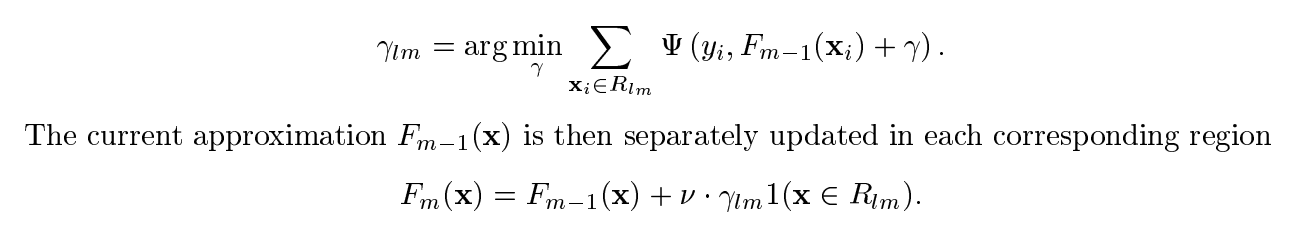


参考别人的分享，使用learning rate decay学习率逐步下降，可以更快的收敛，一开始学习率大，后面学习率很小，避免新的树有过大的影响，通过继续增加树的数量才能达到收敛
也使用了早停，即无论训练进行的如何，在验证集上模型在n棵新的树加上后，依然不能使得测试误差减少，则立刻停止训练。取当前模型为最优模型。
对于boosting由于它可以确定每一轮新加的树都会使整体误差更小，按理说直接用一个很小的学习率就可以了，**为什么learning rate decay还会比恒定很小的学习率有更好的效果**，真的没搞太明白，还请多多指教了。

有意思的是learning rate decay，17年初在刚接触深度学习和Python的课上第一次了解，老师是大牛，不太敢提问，第一次私下问老师的问题就是关于局部最优解和learnign rate的, 那一学期只听懂了一点CNN的东西，但是由衷的欣赏老师和TA的水平和课程。

In [ ]:


def learning_rate_power_0997(current_iter):
    base_learning_rate = 0.1
    min_learning_rate = 0.02
    lr = base_learning_rate  * np.power(.995, current_iter)
    return max(lr, min_learning_rate)


关于模型和它的参数：



这个数据集测试集数量远大于训练集
其他人在讨论中使用过网格搜索，贝叶斯调参等方法，效果并不好，https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough 中直接放弃了使用贝叶斯调参找到的一组参数，而是采用的默认参数。

调参一般是找到参数使得交叉验证的结果，或者单独验证集的误差最小，认为是拟合最好的参数组合。在测试集远多于训练集的情况下，调参有一点过拟合现有数据的趋势，即使这一组参数可以对训练集和验证机表现由于其他参数组合，但是测试集太大了，这组参数没法保证测试集表现一样好。

这里采用了题目讨论中其他人在不同特征，但是同样是LightGBM使用的几组参数，但是没有对参数进行调参优化。

然后设置了四组参数，几个LightGBM模型使用不同的参数和数据切分，弥补单一参数和调参效果差的不足。

特点是每次交叉验证都算一个子模型，都做一次预测，增大了随机性，这个在上次比赛中也有较好效果。

In [ ]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None,random_state_int=101,early_stopping=300):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 
                  
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = 4, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True, random_state= random_state_int)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds =early_stopping, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  callbacks=[lgb.reset_parameter(learning_rate=learning_rate_power_0997)])
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

In [ ]:
hyp1 = {
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.08, 
                   'min_child_samples': 90, 'num_leaves': 34, 'subsample': 0.94, 'reg_lambda': 0.5, 
                   'class_weight': 'balanced'}

hyp2 = {
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.08, 
                   'min_child_samples': 90, 'num_leaves': 14, 'subsample': 0.94, 'reg_lambda': 0.5, 
                   'class_weight': 'balanced'}

hyp3 = {
                  'colsample_bytree': 0.78, 
                  'learning_rate': 0.08, 
                   'min_child_samples': 45, 'num_leaves': 14, 'subsample': 0.64, 'reg_lambda': 0.1, 
                   'class_weight': 'balanced'}

hyp4 = {
                  'colsample_bytree': 0.72, 
                  'learning_rate': 0.08, 
                   'min_child_samples': 30, 'num_leaves': 18, 'subsample': 0.64, 'reg_lambda': 0.1, 
                   'class_weight': 'balanced'}

使用了原始特征训练两个模型，再使用选择后的特征训练一个。并且采用不同参数。

In [ ]:
%%capture --no-display

submission1, gbm_fi_selected, valid_scores_selected = model_gbm(train_set, train_labels, test_set, test_ids,hyp = hyp1,random_state_int=103,early_stopping=300)
submission2, gbm_fi_selected, valid_scores_selected = model_gbm(train_set, train_labels, test_set, test_ids,hyp = hyp1,random_state_int=103,early_stopping=300)
submission3, gbm_fi_selected, valid_scores_selected = model_gbm(train_selected, train_labels, test_selected, test_ids)


下面的模型取消学习率的改变，再训练一个模型

In [ ]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm_2(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None,random_state_int=101,early_stopping=300):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 
                  
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = 4, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True, random_state= random_state_int)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds =early_stopping, 
                  eval_metric = macro_f1_score,
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['macro_f1'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['idhogar'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    # Merge with the base to have one prediction for each individual
    submission = submission_base.merge(predictions[['idhogar', 'Target']], on = 'idhogar', how = 'left').drop(columns = ['idhogar'])
        
    # Fill in the individuals that do not have a head of household with 4 since these will not be scored
    submission['Target'] = submission['Target'].fillna(4).astype(np.int8)
    
    # return the submission and feature importances along with validation scores
    return submission, feature_importances, valid_scores

In [ ]:
%%capture --no-display
submission4, gbm_fi_selected, valid_scores_selected = model_gbm_2(train_set, train_labels, test_set, test_ids,hyp = hyp3,random_state_int=103,early_stopping=300)

In [ ]:
suball=submission1.merge(submission2, on='Id')
suball=suball.merge(submission4, on='Id')
suball=suball.merge(submission3, on='Id')
suball_2=suball.merge(submission4, on='Id')

对于每行测试数据五个模型投票，得票最多的结果作为最终贫穷程度

In [ ]:
#加入一个index即序号，以方便merge结果到原数据
suball_2['index']=suball_2.index

In [ ]:
modle_13= pd.DataFrame(suball_2.mode(axis=1)[0])

In [ ]:
modle_13['index']=modle_13.index

In [ ]:
modle_13.head()

In [ ]:
final = suball_2.merge(modle_13, on ='index')

In [ ]:
final_res=final[['Id',0]]

In [ ]:
final_res.columns=['Id','Target']

In [ ]:
final_res.to_csv('4_model_vote.csv',index=False)